<a href="https://colab.research.google.com/github/hongkyuh/colab_test/blob/main/API_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## cifar10 데이터셋

(50000, 32, 32, 3) (10000, 32, 32, 3)


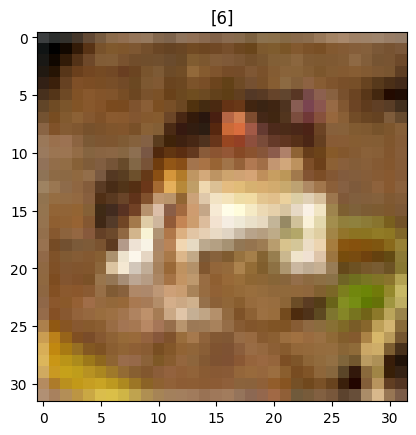

훈련 데이터 형태: (50000, 3072)
테스트 데이터 형태: (10000, 3072)
Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 3072)]       0                                            
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 256)          786688      input_13[0][0]                   
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 2)            514         dense_30[0][0]                   
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 2)            514         dense_30[0][0]                   
________________________________________

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54984 (\N{HANGUL SYLLABLE HUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47144 (\N{HANGUL SYLLABLE RYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


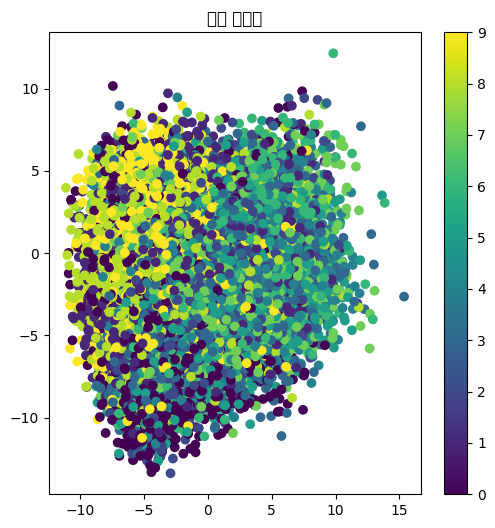

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


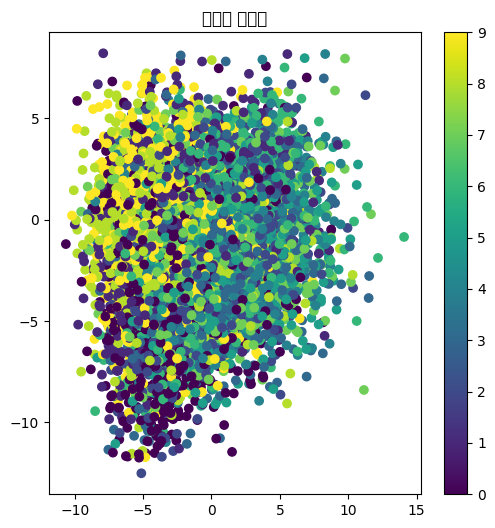

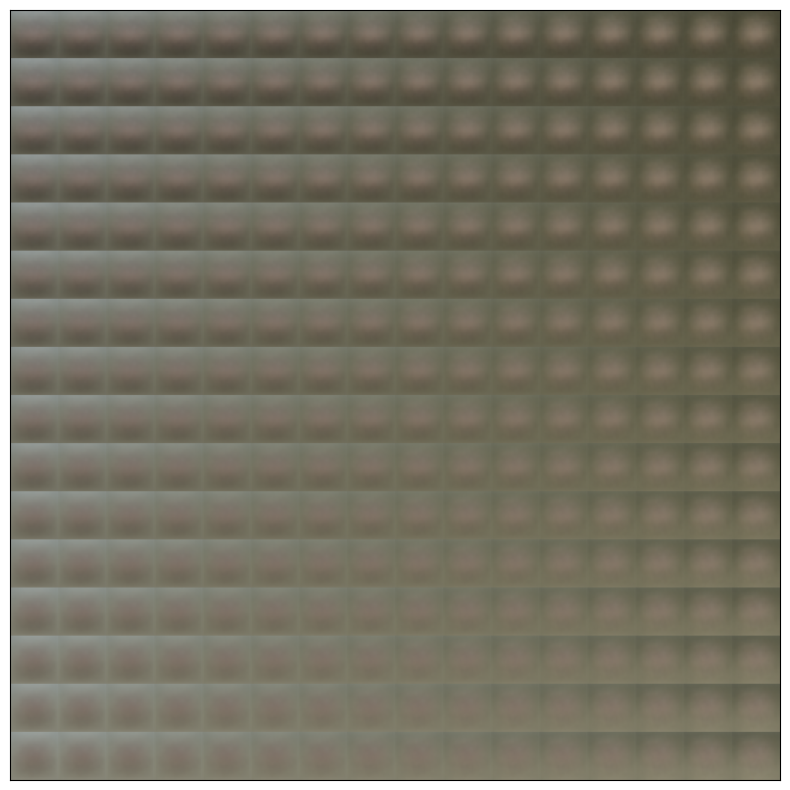

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

# CIFAR-10 데이터셋 불러오기
(x_train, t_train), (x_test, t_test) = cifar10.load_data()  # CIFAR-10 데이터셋
print(x_train.shape, x_test.shape)  # (50000, 32, 32, 3) (10000, 32, 32, 3)

x_train = x_train / 255.0
x_test = x_test / 255.0

# 데이터셋에서 이미지 하나 출력
plt.imshow(x_train[0])
plt.title(t_train[0])
plt.show()

# 데이터 형태 변경 (1차원으로)
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
print("훈련 데이터 형태:", x_train.shape)
print("테스트 데이터 형태:", x_test.shape)

epochs = 10
batch_size = 128
n_in_out = 3072  # CIFAR-10의 입력/출력 레이어 크기 (32x32x3)
n_z = 2  # 잠재 변수의 수 (차원)
n_mid = 256  # 중간 레이어의 뉴런 수

from tensorflow.python.keras.models import Model
from tensorflow.python.keras import metrics
from tensorflow.python.keras.layers import Input, Dense, Lambda
from tensorflow.python.keras import backend as K

# 잠재 변수 샘플링을 위한 함수
def z_sample(args):
    mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(log_var), mean=0, stddev=1)
    return mu + epsilon

# Encoder
x = Input(shape=(n_in_out,))
h_encoder = Dense(n_mid, activation="relu")(x)
mu = Dense(n_z)(h_encoder)
log_var = Dense(n_z)(h_encoder)
z = Lambda(z_sample, output_shape=(n_z,))([mu, log_var])

# Decoder
mid_decoder = Dense(n_mid, activation="relu")
h_decoder = mid_decoder(z)
out_decoder = Dense(n_in_out, activation="sigmoid")
y = out_decoder(h_decoder)

# VAE 모델
model_vae = Model(x, y)

# 손실 함수
eps = 1e-7
rec_loss = K.sum(-x * K.log(y + eps) - (1 - x) * K.log(1 - y + eps)) / batch_size
reg_loss = -0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var)) / batch_size
vae_loss = rec_loss + reg_loss

model_vae.add_loss(vae_loss)
model_vae.compile(optimizer="adam")
model_vae.summary()

model_vae.fit(x_train, x_train,
              shuffle=True,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_test, None))

# Encoder 모델을 사용하여 잠재 변수 얻기
encoder = Model(x, z)
z_train = encoder.predict(x_train, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_train[:, 0], z_train[:, 1], c=t_train)
plt.title("훈련 데이터")
plt.colorbar()
plt.show()

z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=t_test)
plt.title("테스트 데이터")
plt.colorbar()
plt.show()

# 이미지 생성을 위한 Generator 모델
input_decoder = Input(shape=(n_z,))
h_decoder = mid_decoder(input_decoder)
y = out_decoder(h_decoder)
generator = Model(input_decoder, y)

# 잠재 변수를 변화시켜 이미지 생성
n = 16
image_size = 32
matrix_image = np.zeros((image_size * n, image_size * n, 3))  # RGB 이미지에 맞게 크기 조정

z_1 = np.linspace(2, -2, n)
z_2 = np.linspace(-2, 2, n)

for i, z1 in enumerate(z_1):
    for j, z2 in enumerate(z_2):
        decoded = generator.predict(np.array([[z2, z1]]))
        image = decoded[0].reshape(image_size, image_size, 3)
        matrix_image[i * image_size: (i + 1) * image_size, j * image_size: (j + 1) * image_size] = image

plt.figure(figsize=(10, 10))
plt.imshow(matrix_image)
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
plt.show()

## fashion mnist 데이터셋

(60000, 28, 28) (10000, 28, 28)


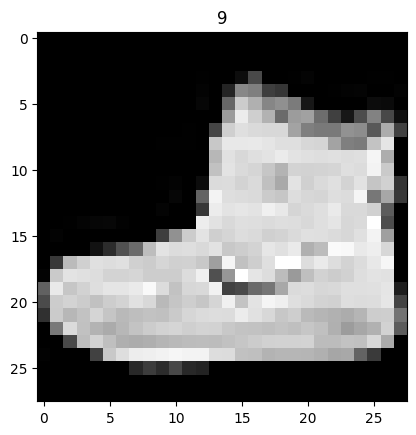

훈련용 데이터의 형태: (60000, 784) 테스트용 데이터의 형태: (10000, 784)
Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_35 (Dense)                (None, 256)          200960      input_15[0][0]                   
__________________________________________________________________________________________________
dense_36 (Dense)                (None, 2)            514         dense_35[0][0]                   
__________________________________________________________________________________________________
dense_37 (Dense)                (None, 2)            514         dense_35[0][0]                   
______________________________________

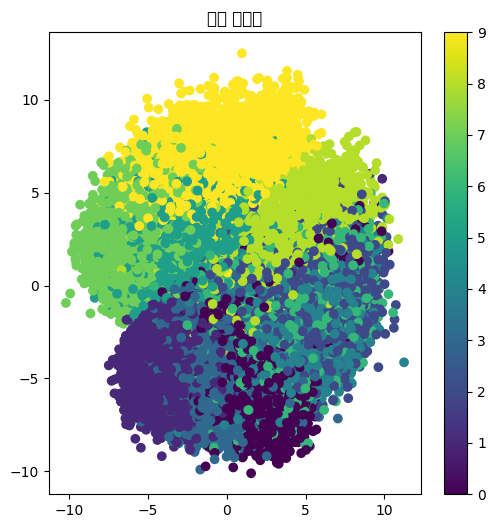

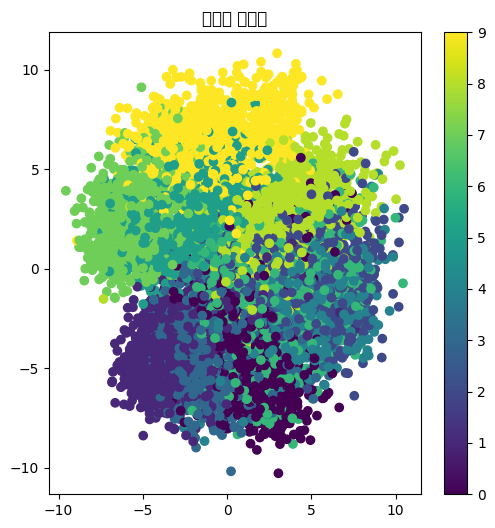

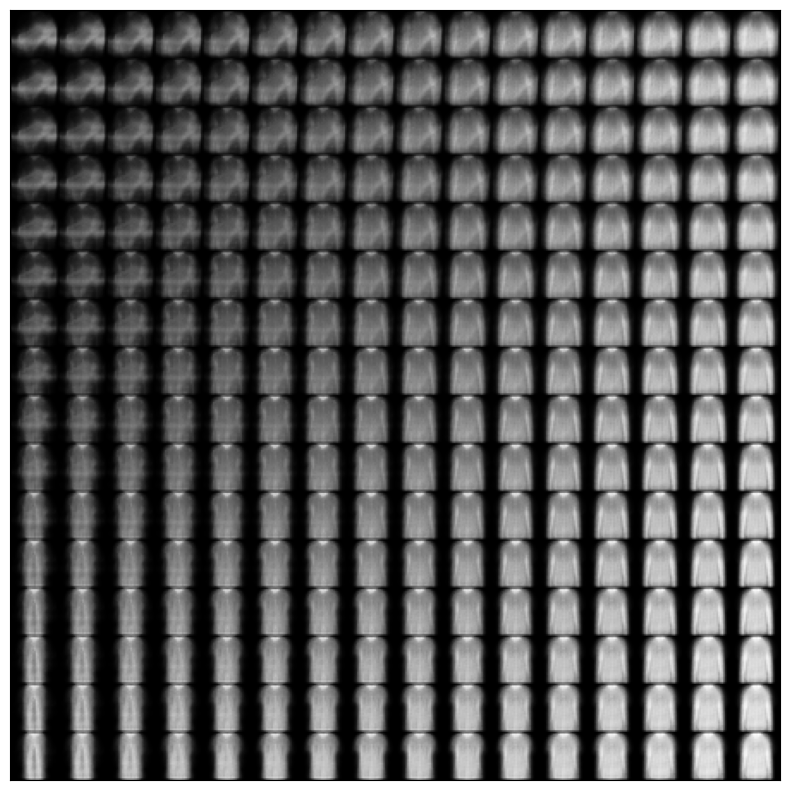

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

# Fashion MNIST 데이터셋 불러오기
(x_train, t_train), (x_test, t_test) = fashion_mnist.load_data()
print(x_train.shape, x_test.shape)

x_train = x_train / 255
x_test = x_test / 255

plt.imshow(x_train[0].reshape(28, 28), cmap="gray")
plt.title(t_train[0])
plt.show()

x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
print("훈련용 데이터의 형태:", x_train.shape, "테스트용 데이터의 형태:", x_test.shape)

epochs = 10
batch_size = 128
n_in_out = 784
n_z = 2
n_mid = 256

from tensorflow.python.keras.models import Model
from tensorflow.python.keras import metrics
from tensorflow.python.keras.layers import Input, Dense, Lambda
from tensorflow.python.keras import backend as K

def z_sample(args):
    mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(log_var), mean=0, stddev=1)
    return mu + epsilon

x = Input(shape=(n_in_out,))
h_encoder = Dense(n_mid, activation="relu")(x)
mu = Dense(n_z)(h_encoder)
log_var = Dense(n_z)(h_encoder)
z = Lambda(z_sample, output_shape=(n_z,))([mu, log_var])

mid_decoder = Dense(n_mid, activation="relu")
h_decoder = mid_decoder(z)
out_decoder = Dense(n_in_out, activation="sigmoid")
y = out_decoder(h_decoder)

model_vae = Model(x, y)

eps = 1e-7
rec_loss = K.sum(-x * K.log(y + eps) - (1 - x) * K.log(1 - y + eps)) / batch_size
reg_loss = -0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var)) / batch_size
vae_loss = rec_loss + reg_loss

model_vae.add_loss(vae_loss)
model_vae.compile(optimizer="adam")
model_vae.summary()

model_vae.fit(x_train, x_train,
              shuffle=True,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_test, None))

encoder = Model(x, z)

z_train = encoder.predict(x_train, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_train[:, 0], z_train[:, 1], c=t_train)
plt.title("훈련 데이터")
plt.colorbar()
plt.show()

z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=t_test)
plt.title("테스트 데이터")
plt.colorbar()
plt.show()

input_decoder = Input(shape=(n_z,))
h_decoder = mid_decoder(input_decoder)
y = out_decoder(h_decoder)
generator = Model(input_decoder, y)

n = 16
image_size = 28
matrix_image = np.zeros((image_size * n, image_size * n))

z_1 = np.linspace(2, -2, n)
z_2 = np.linspace(-2, 2, n)

for i, z1 in enumerate(z_1):
    for j, z2 in enumerate(z_2):
        decoded = generator.predict(np.array([[z2, z1]]))
        image = decoded[0].reshape(image_size, image_size)
        matrix_image[i * image_size: (i + 1) * image_size, j * image_size: (j + 1) * image_size] = image

plt.figure(figsize=(10, 10))
plt.imshow(matrix_image, cmap="Greys_r")
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
plt.show()